In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read raw data
df_raw = pd.read_csv("../datasets/measured/20A_01.CSV")
df_raw = df_raw.rename(columns = {
    "in s": "t",
    "C1 in V": "Va",
    "C2 in A": "Ia",
    "C3 in V": "n"
})
df_raw

,t,Va,Ia,n
0,-0.024200,-0.027832,-0.268555,0.135547
1,-0.024197,-0.013184,-0.268555,0.076953
2,-0.024195,-0.013184,-0.366211,0.096484
3,-0.024193,-0.013184,-0.610352,0.116016
4,-0.024190,-0.042480,-0.317383,0.135547
...,...,...,...,...
99995,0.215788,11.954600,2.612300,0.116016
99996,0.215791,12.013200,2.954100,4.608200
99997,0.215793,12.013200,2.807620,0.018359
99998,0.215795,11.910600,2.709960,4.588670


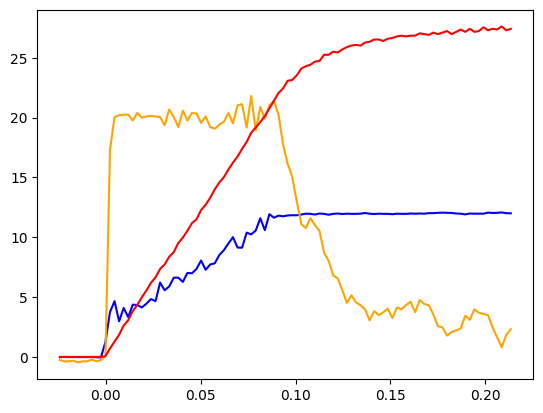

,t,Va,Ia,Wm
0,-0.0242,-0.027832,-0.268555,0.000000
1000,-0.0218,0.001465,-0.366211,0.000000
2000,-0.0194,-0.013184,-0.366211,0.000000
3000,-0.0170,-0.013184,-0.317383,0.000000
4000,-0.0146,-0.013184,-0.463867,0.000000
...,...,...,...,...
95000,0.2038,12.027800,2.465820,548.398132
96000,0.2062,12.042500,1.635740,547.119814
97000,0.2086,12.071800,0.805664,552.233084
98000,0.2110,12.013200,1.831050,545.841497


In [490]:
from dcmotor import get_rising_edges

# Downsampling
df_downsampled = pd.DataFrame()

num_steps = 2048
start = True
time_step_raw = df_raw["t"].diff().iloc[1]
batch_size = 1000

time_step = time_step_raw * batch_size

df_downsampled["t"] = df_raw["t"].iloc[::batch_size]
df_downsampled["Va"] = df_raw["Va"].iloc[::batch_size]
df_downsampled["Ia"] = df_raw["Ia"].iloc[::batch_size]
df_downsampled["Wm"] = np.array(get_rising_edges(df_raw["n"].array, 2048, 4, time_step_raw, batch_size)) * np.pi * 2

plt.plot(df_downsampled["t"], df_downsampled["Va"], c="blue")
plt.plot(df_downsampled["t"], df_downsampled["Ia"], c="orange")
plt.plot(df_downsampled["t"], df_downsampled["Wm"]/20, c="red")
plt.show()
df_downsampled

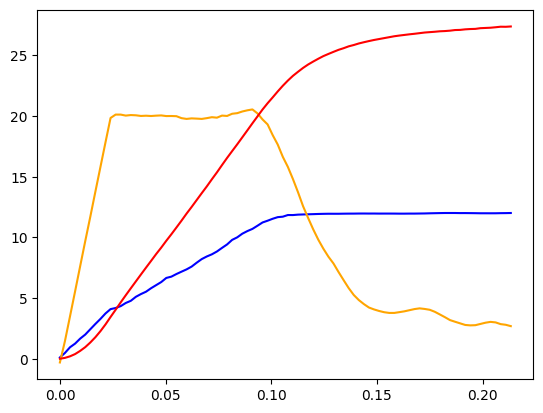

,t,Va,Ia,Wm
10000,-0.0002,0.109863,-0.302734,0.127832
11000,0.0022,0.484863,1.464847,1.533981
12000,0.0046,0.952148,3.505858,4.090615
13000,0.0070,1.250976,5.556636,7.797736
14000,0.0094,1.661133,7.626953,13.038837
...,...,...,...,...
95000,0.2038,11.986790,3.041992,545.458002
96000,0.2062,11.988260,2.998046,546.224992
97000,0.2086,11.997050,2.856444,547.119814
98000,0.2110,12.001450,2.802733,546.991983


In [491]:
# Low pass filtering
df_filtered = pd.DataFrame()

rolling_width = 10

df_filtered["t"] = df_downsampled["t"]
df_filtered["Va"] = df_downsampled["Va"].rolling(rolling_width).mean()
df_filtered["Ia"] = df_downsampled["Ia"].rolling(rolling_width).mean()
df_filtered["Wm"] = df_downsampled["Wm"].rolling(rolling_width).mean()

df_filtered = df_filtered.iloc[rolling_width:]

plt.plot(df_filtered["t"], df_filtered["Va"], c="blue")
plt.plot(df_filtered["t"], df_filtered["Ia"], c="orange")
plt.plot(df_filtered["t"], df_filtered["Wm"]/20, c="red")
plt.show()
df_filtered

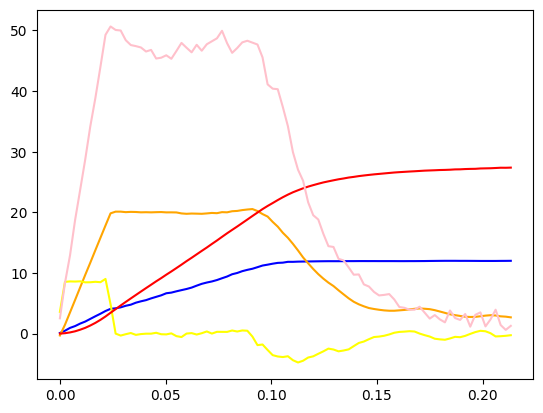

,t,Va,Ia,Wm,dIa,dWm
10000,-0.0002,0.109863,-0.302734,0.127832,358.751965,253.000304
11000,0.0022,0.484863,1.464847,1.533981,854.491913,834.457142
12000,0.0046,0.952148,3.505858,4.090615,861.271806,1291.633129
13000,0.0070,1.250976,5.556636,7.797736,859.239681,1873.089967
14000,0.0094,1.661133,7.626953,13.038837,862.971361,2370.213370
...,...,...,...,...,...,...
95000,0.2038,11.986790,3.041992,545.458002,7.290056,235.245896
96000,0.2062,11.988260,2.998046,546.224992,-45.606986,395.035562
97000,0.2086,11.997050,2.856444,547.119814,-42.046465,142.035258
98000,0.2110,12.001450,2.802733,546.991983,-35.434146,62.140425


In [492]:
from dcmotor import five_point_stencil

# Get derivatives
df = pd.DataFrame(df_filtered)
df["dIa"] = five_point_stencil(df_filtered["Ia"].array, time_step)
df["dWm"] = five_point_stencil(df_filtered["Wm"].array, time_step)

plt.plot(df["t"], df["Va"], c="blue")
plt.plot(df["t"], df["Ia"], c="orange")
plt.plot(df["t"], df["dIa"]/100, c="yellow")
plt.plot(df["t"], df["Wm"]/20, c="red")
plt.plot(df["t"], df["dWm"]/100, c="pink")
plt.show()
df

In [493]:
# Linear regression

# Circuit Equation
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Ke*i = TL + Jm*dw/dt + Bm*w

Ra = 0.091
Ke = 18.803 / 1000
TL = 0

t = np.array(df["t"].array)

Va = np.array(df["Va"].array)

Ia = np.array(df["Ia"].array)
dIa = np.array(df["dIa"].array)

Wm = np.array(df["Wm"].array)
dWm = np.array(df["dWm"].array)

In [494]:
R_t = np.zeros((3,3))
h_t = np.zeros((3,1))
lambda_t = 0
theta_t = np.zeros((3,1))
S0 = 1

# Circuit equation
# Va - Ke*w = i*Ra + L*di/dt 

for k in range(len(t)):
    y = np.vstack([Va[k]])
    X = np.array([
        [Ia[k], dIa[k], Wm[k]],
    ])
    R_t = X.T @ X + lambda_t * R_t
    h_t = X.T @ y + lambda_t * h_t

    if np.linalg.det(R_t) != 0:
        P_t = np.linalg.inv(R_t)
        theta_t = P_t @ h_t
        sigma = (y - X @ theta_t).sum()
        lambda_t = 1 - (sigma ** 2) / (S0 * (1 + X @ P_t @ X.T))

print("Batch size:", batch_size)
theta = theta_t
Ra_pred, La_pred, Ke_pred = theta.T[0][:3]

print("Ra", Ra_pred)
print("La", La_pred)
print("Ke", Ke_pred)

Batch size: 1000
Ra 0.12050087134301901
La 0.0002730448572910282
Ke 0.021565467287202707


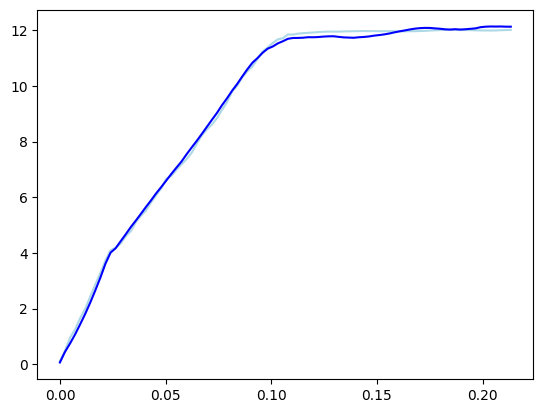

In [495]:
# Equations
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w
# TL = Kt*i - Jm*dw/dt - Bm*w

Va_pred = Ia*Ra_pred + La_pred*dIa + Ke_pred*Wm

plt.plot(t, Va, c="lightblue")
plt.plot(t, Va_pred, c="blue")
plt.show()

In [496]:
R_t = np.zeros((2,2))
h_t = np.zeros((2,1))
lambda_t = 0
theta_t = np.zeros((2,1))

# Torque Equation
# Ke*i - TL = Jm*dw/dt + Bm*w

for k in range(len(t)):
    y = np.vstack([Ke_pred * Ia[k] - TL])
    X = np.array([
        [dWm[k], Wm[k]],
    ])
    R_t = X.T @ X + lambda_t * R_t
    h_t = X.T @ y + lambda_t * h_t

    if np.linalg.det(R_t) != 0:
        P_t = np.linalg.inv(R_t)
        theta_t = P_t @ h_t
        sigma = (y - X @ theta_t).sum()
        lambda_t = 1 - (sigma ** 2) / (S0 * (1 + X @ P_t @ X.T))

print("Batch size:", batch_size)
theta = theta_t
Jm_pred, Bm_pred = theta.T[0][:2]

print("Jm", Jm_pred)
print("Bm", Bm_pred)

Batch size: 1000
Jm 8.540399078973828e-05
Bm 8.84394590035123e-05


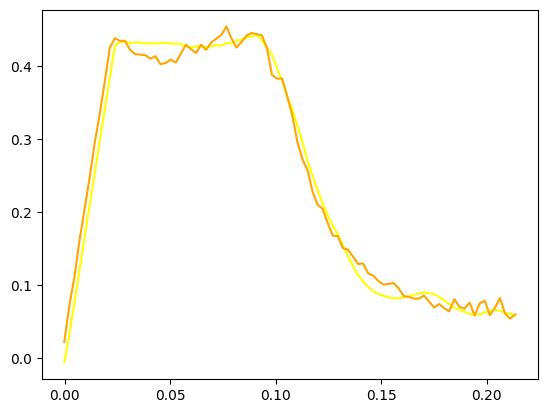

In [497]:
# Equations
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w
# TL = Kt*i - Jm*dw/dt - Bm*w

Tm = Ke_pred * Ia
Tm_pred = TL + Jm_pred*dWm + Bm_pred*Wm

plt.plot(t, Tm, c="yellow")
plt.plot(t, Tm_pred, c="orange")
plt.show()